Dataset shape: (2469, 5)
           Date      Open      High       Low     Close
0  1-April-2014  22455.23  22485.77  22295.65  22446.44
1  2-April-2014  22550.58  22592.10  22473.46  22551.49
2  3-April-2014  22598.19  22620.65  22369.28  22509.07
3  4-April-2014  22522.46  22525.21  22339.40  22359.50
4  7-April-2014  22355.56  22481.62  22197.51  22343.45
Using column for prediction: Close


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.3482
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0355
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0146
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0097
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0073
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0066
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0065
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0056
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0059
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0058
Epoch 16/2

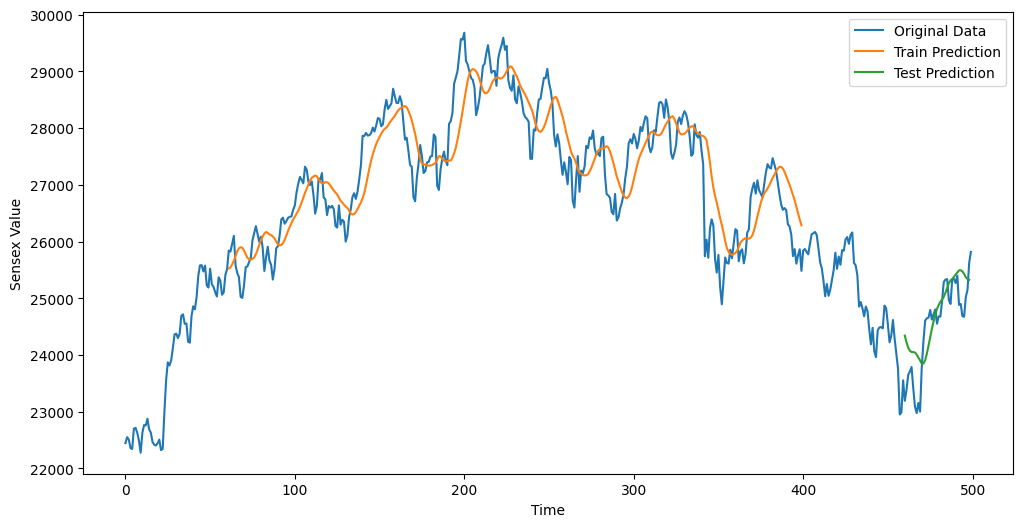

In [ ]:
# --- Step 1: Install dependencies (Colab usually has them preinstalled)
!pip install tensorflow pandas matplotlib scikit-learn --quiet

# --- Step 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# --- Step 3: Load dataset
file_path = "/content/BSE SENSEX.csv"  # Change if file path is different
df = pd.read_csv(file_path)

print("Dataset shape:", df.shape)
print(df.head())

# --- Step 4: Use only first 500 rows
df = df.head(500)

# If dataset has 'Close' or similar column, use it; else take last numeric column
target_column = None
for col in df.columns:
    if 'Close' in col or 'close' in col:
        target_column = col
        break

if target_column is None:
    target_column = df.select_dtypes(include=[np.number]).columns[-1]

print("Using column for prediction:", target_column)

# --- Step 5: Preprocessing
data = df[[target_column]].values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# --- Step 6: Create sequences
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 0])
        y.append(dataset[i+time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# --- Step 7: Build LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# --- Step 8: Train model
history = model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1)

# --- Step 9: Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse scaling
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

# --- Step 10: Plot Results
plt.figure(figsize=(12,6))
plt.plot(df.index, data, label="Original Data")

# Plot train predictions
train_idx = list(range(time_step+1, len(train_predict)+time_step+1))
plt.plot(train_idx, train_predict, label="Train Prediction")

# Plot test predictions
test_idx = list(range(len(train_predict)+(time_step*2)+1, len(data)-1))
plt.plot(test_idx, test_predict, label="Test Prediction")

plt.xlabel("Time")
plt.ylabel("Sensex Value")
plt.legend()
plt.show()


Original Dataset shape: (2469, 5)
           Date      Open      High       Low     Close
0  1-April-2014  22455.23  22485.77  22295.65  22446.44
1  2-April-2014  22550.58  22592.10  22473.46  22551.49
2  3-April-2014  22598.19  22620.65  22369.28  22509.07
3  4-April-2014  22522.46  22525.21  22339.40  22359.50
4  7-April-2014  22355.56  22481.62  22197.51  22343.45
Using column for prediction: Close
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2031
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0132
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0076
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0083
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0072
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0062
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0065
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0061
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0061
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0055
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0058
Epoch 16/20
11/11 ━━

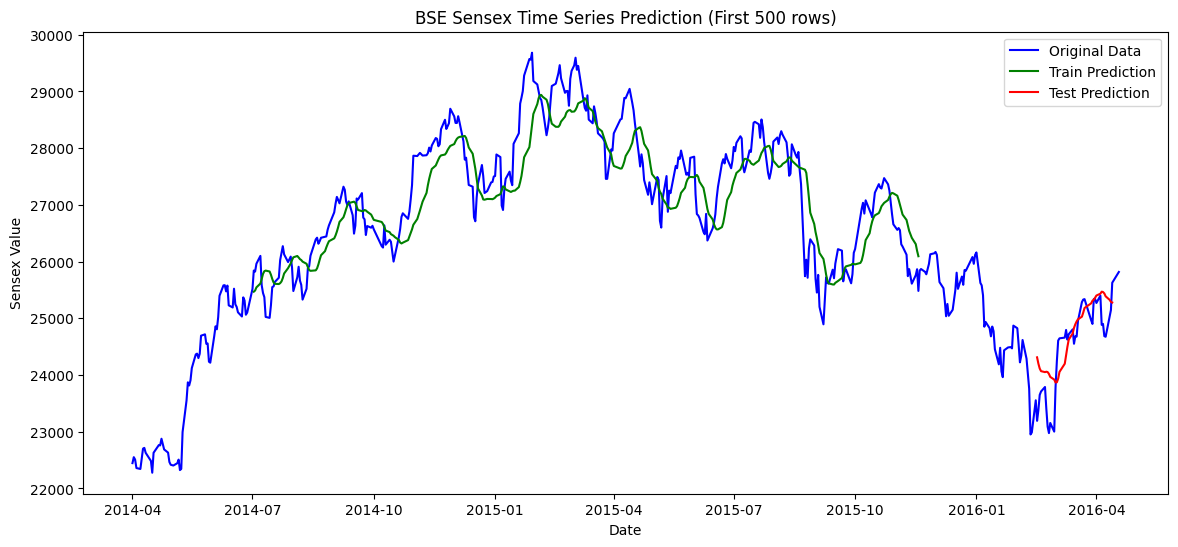

In [ ]:
# --- Step 1: Install dependencies (Colab usually has them preinstalled)
!pip install tensorflow pandas matplotlib scikit-learn --quiet

# --- Step 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# --- Step 3: Load dataset
file_path = "/content/BSE SENSEX.csv"  # Change if file path is different
df = pd.read_csv(file_path)

print("Original Dataset shape:", df.shape)
print(df.head())

# --- Step 4: Use only first 500 rows
df = df.head(500)

# --- Step 5: Handle Date column
if 'Date' in df.columns or 'date' in df.columns:
    date_col = 'Date' if 'Date' in df.columns else 'date'
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)

# --- Step 6: Choose target column (Close price usually)
target_column = None
for col in df.columns:
    if 'Close' in col or 'close' in col:
        target_column = col
        break

if target_column is None:  # fallback: last numeric column
    target_column = df.select_dtypes(include=[np.number]).columns[-1]

print("Using column for prediction:", target_column)

# --- Step 7: Preprocessing
data = df[[target_column]].values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# --- Step 8: Create sequences
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 0])
        y.append(dataset[i+time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# --- Step 9: Build LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# --- Step 10: Train model
history = model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1)

# --- Step 11: Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse scaling
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

# --- Step 12: Plot Results with Dates
plt.figure(figsize=(14,6))
plt.plot(df.index, data, label="Original Data", color="blue")

# Train predictions
train_dates = df.index[time_step+1 : len(train_predict)+time_step+1]
plt.plot(train_dates, train_predict, label="Train Prediction", color="green")

# Test predictions
test_dates = df.index[len(train_predict)+(time_step*2)+1 : len(data)-1]
plt.plot(test_dates, test_predict, label="Test Prediction", color="red")

plt.xlabel("Date")
plt.ylabel("Sensex Value")
plt.title("BSE Sensex Time Series Prediction (First 500 rows)")
plt.legend()
plt.show()


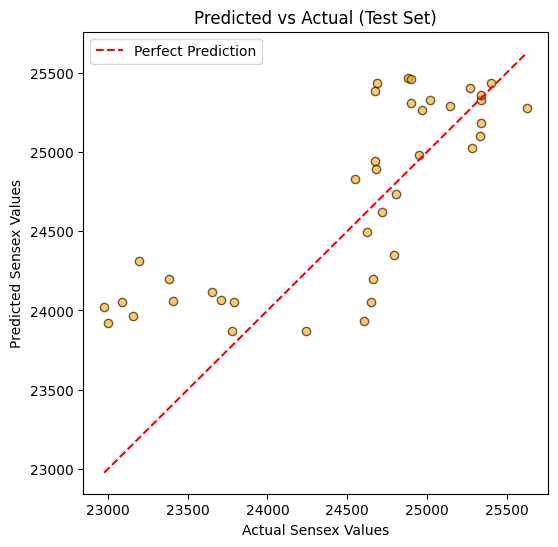

In [ ]:
# --- Predicted vs Actual Scatter Plot ---
plt.figure(figsize=(6,6))
plt.scatter(y_test_inv, test_predict, alpha=0.6, color="orange", edgecolor="black")
plt.xlabel("Actual Sensex Values")
plt.ylabel("Predicted Sensex Values")
plt.title("Predicted vs Actual (Test Set)")

# Add perfect prediction line
min_val = min(y_test_inv.min(), test_predict.min())
max_val = max(y_test_inv.max(), test_predict.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Perfect Prediction")

plt.legend()
plt.show()
